In [264]:
pip install sdv

In [265]:
pip install table_evaluator

In [266]:
import pandas as pd

from sdmetrics.reports.single_table import QualityReport
from ctgan import CTGAN

from rdt import HyperTransformer

In [267]:
real_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSV_FILE/Iris.csv")

In [268]:
df = pd.DataFrame(real_data)

print(df.columns)

print("Original DataFrame:")
print(df)


Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')
Original DataFrame:
      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species

In [269]:
NUM_ROWS = 100
NUM_EPOCHS = 1000
BATCH_SIZE = 500

In [270]:
df.shape

(150, 6)

In [271]:
ht = HyperTransformer()
ht.detect_initial_config(data = df)
detected_config = ht.get_config()
display(detected_config)

{
    "sdtypes": {
        "Id": "numerical",
        "SepalLengthCm": "numerical",
        "SepalWidthCm": "numerical",
        "PetalLengthCm": "numerical",
        "PetalWidthCm": "numerical",
        "Species": "categorical"
    },
    "transformers": {
        "Id": FloatFormatter(),
        "SepalLengthCm": FloatFormatter(),
        "SepalWidthCm": FloatFormatter(),
        "PetalLengthCm": FloatFormatter(),
        "PetalWidthCm": FloatFormatter(),
        "Species": UniformEncoder()
    }
}

In [272]:
ht.fit(df)
transformed_df = ht.transform(df)
transformed_df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1.0,5.1,3.5,1.4,0.2,0.164399
1,2.0,4.9,3.0,1.4,0.2,0.028452
2,3.0,4.7,3.2,1.3,0.2,0.031254
3,4.0,4.6,3.1,1.5,0.2,0.282119
4,5.0,5.0,3.6,1.4,0.2,0.225274
...,...,...,...,...,...,...
145,146.0,6.7,3.0,5.2,2.3,0.748878
146,147.0,6.3,2.5,5.0,1.9,0.967718
147,148.0,6.5,3.0,5.2,2.0,0.861117
148,149.0,6.2,3.4,5.4,2.3,0.932372


In [273]:
import time

start_time = time.time()  # Capture start time before training

model = CTGAN(
    epochs=NUM_EPOCHS,
    verbose=True,
    batch_size=BATCH_SIZE,
    embedding_dim = 1024,
    discriminator_steps = 6,
    discriminator_dim = (512,512)
)

model.fit(transformed_df)

# Training is finished, record end time
end_time = time.time()

# Calculate total training time in seconds
training_time = end_time - start_time

print(f"Training completed! Total time taken: {training_time:.2f} seconds")

model.save("/content/drive/MyDrive/Colab Notebooks/CSV_FILE/Models/iris_1000epochs_500BS_1024_6_512.pkl")

Gen. (-0.01) | Discrim. (-0.68): 100%|██████████| 1000/1000 [09:55<00:00,  1.68it/s]

Training completed! Total time taken: 596.53 seconds


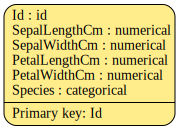

In [274]:
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
metadata_dict= metadata.to_dict()
metadata.visualize()

In [275]:
categorical_columns = [column for column, info in metadata_dict['columns'].items() if info['sdtype'] == 'categorical']
print(categorical_columns)

['Species']


In [276]:
from sdmetrics.reports.single_table import QualityReport

# Get Synthetic data
synthetic_data = model.sample(NUM_ROWS)
# reverse transform the data
synthetic_data = ht.reverse_transform(synthetic_data)

report = QualityReport()
# Use the metadata OBJECT instead of the dictionary
report.generate(df, synthetic_data, metadata.to_dict())

cs_report = report.get_details(property_name="Column Shapes")
print(cs_report)

# Create the first figure
fig1 = report.get_visualization(property_name='Column Shapes')
fig1.show()

# Create the second figure
fig2 = report.get_visualization(property_name='Column Pair Trends')
fig2.show()

report.save(filepath='/content/drive/MyDrive/Colab Notebooks/CSV_FILE/Models/iris_report_1000epochs_500BS_1024_6_512.pkl')

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00, 541.53it/s]|
Column Shapes Score: 86.47%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 73.58it/s]| 
Column Pair Trends Score: 81.31%

Overall Score (Average): 83.89%

          Column        Metric     Score
0  SepalLengthCm  KSComplement  0.870000
1   SepalWidthCm  KSComplement  0.846667
2  PetalLengthCm  KSComplement  0.890000
3   PetalWidthCm  KSComplement  0.860000
4        Species  TVComplement  0.856667


In [277]:
from sdmetrics.single_column import CSTest

for column in categorical_columns:
    cstest_result = CSTest.compute(
        real_data=df[column],
        synthetic_data=synthetic_data[column]
    )
    print(f"CSTest for column {column}: {cstest_result}")

CSTest for column Species: 0.9547554925746483


In [278]:
from sdmetrics.visualization import get_column_plot

# Loop through each column in the dataframe
for column in df.columns:
    fig = get_column_plot(
        real_data=df,
        synthetic_data=synthetic_data,
        column_name=column,
    )

    fig.show()

In [279]:
display(synthetic_data)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,104,5.423304,2.884901,4.632228,1.939118,Iris-virginica
1,81,5.326742,2.631638,3.218180,1.249934,Iris-setosa
2,52,5.712609,3.265394,4.440359,1.689444,Iris-setosa
3,106,5.577306,2.367454,4.326265,0.943981,Iris-virginica
4,10,4.502649,4.709066,1.893229,0.432372,Iris-setosa
...,...,...,...,...,...,...
95,131,5.858793,3.038714,4.621559,1.528545,Iris-versicolor
96,14,4.786050,3.042530,0.984551,0.101243,Iris-setosa
97,127,6.039349,3.205812,4.191150,1.689604,Iris-virginica
98,41,6.055466,3.321210,4.412469,1.198574,Iris-versicolor


In [280]:
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages

# Get all column pairs
column_pairs = combinations(df.columns, 2)

# Loop through each column pair
for column1, column2 in column_pairs:
  # Generate the plot using get_column_pair_plot
  fig = get_column_pair_plot(
      real_data=df,
      synthetic_data=synthetic_data,
      column_names=[column1, column2]
  )


  fig.show()


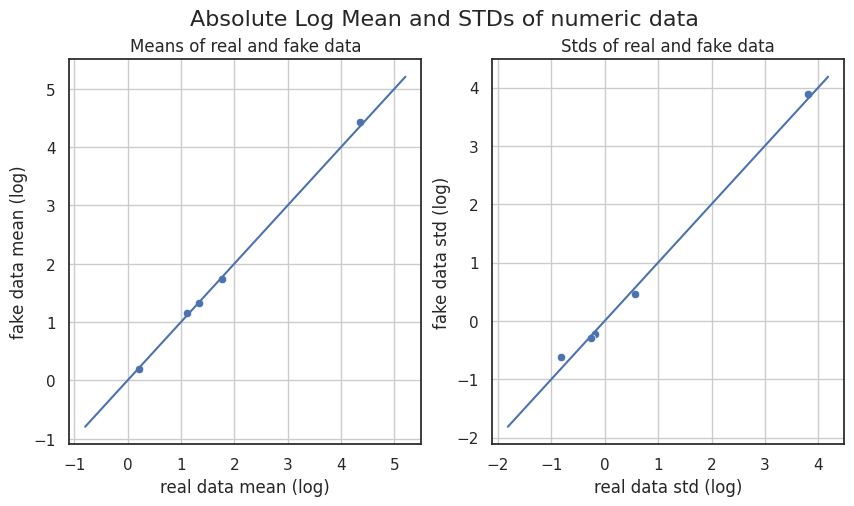

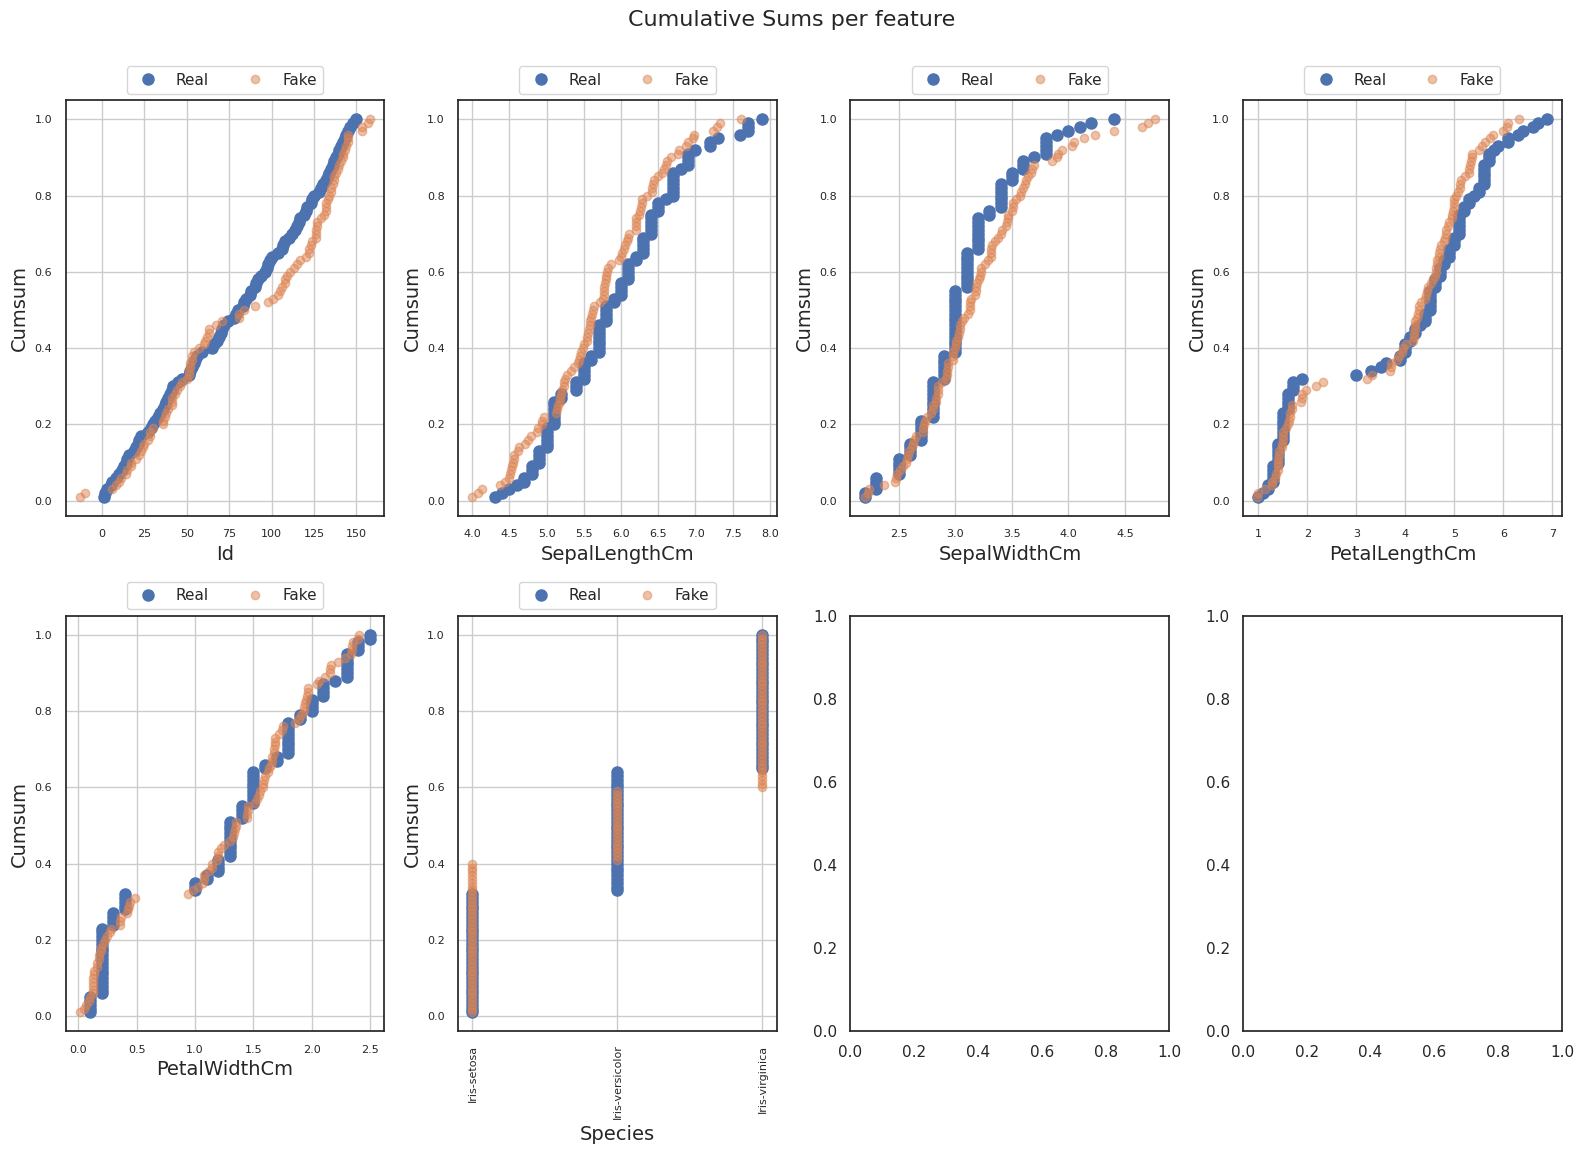

/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:182: UserWarning:

FixedFormatter should only be used together with FixedLocator



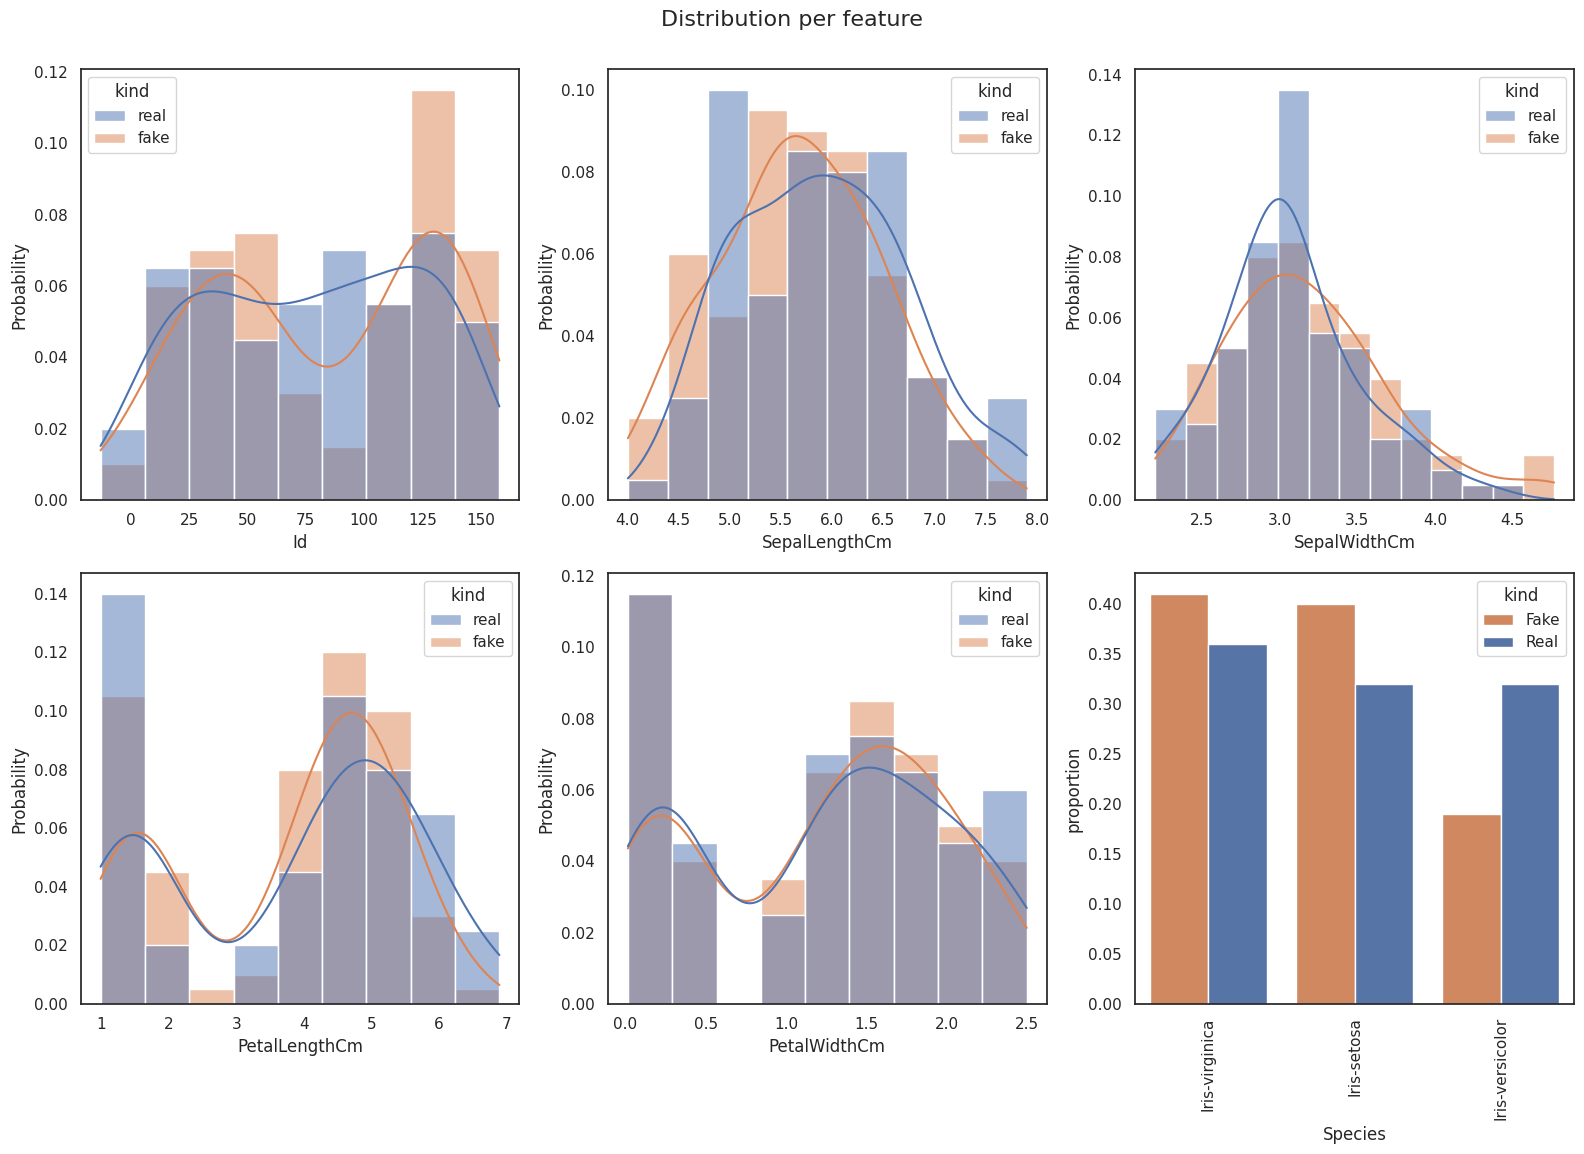

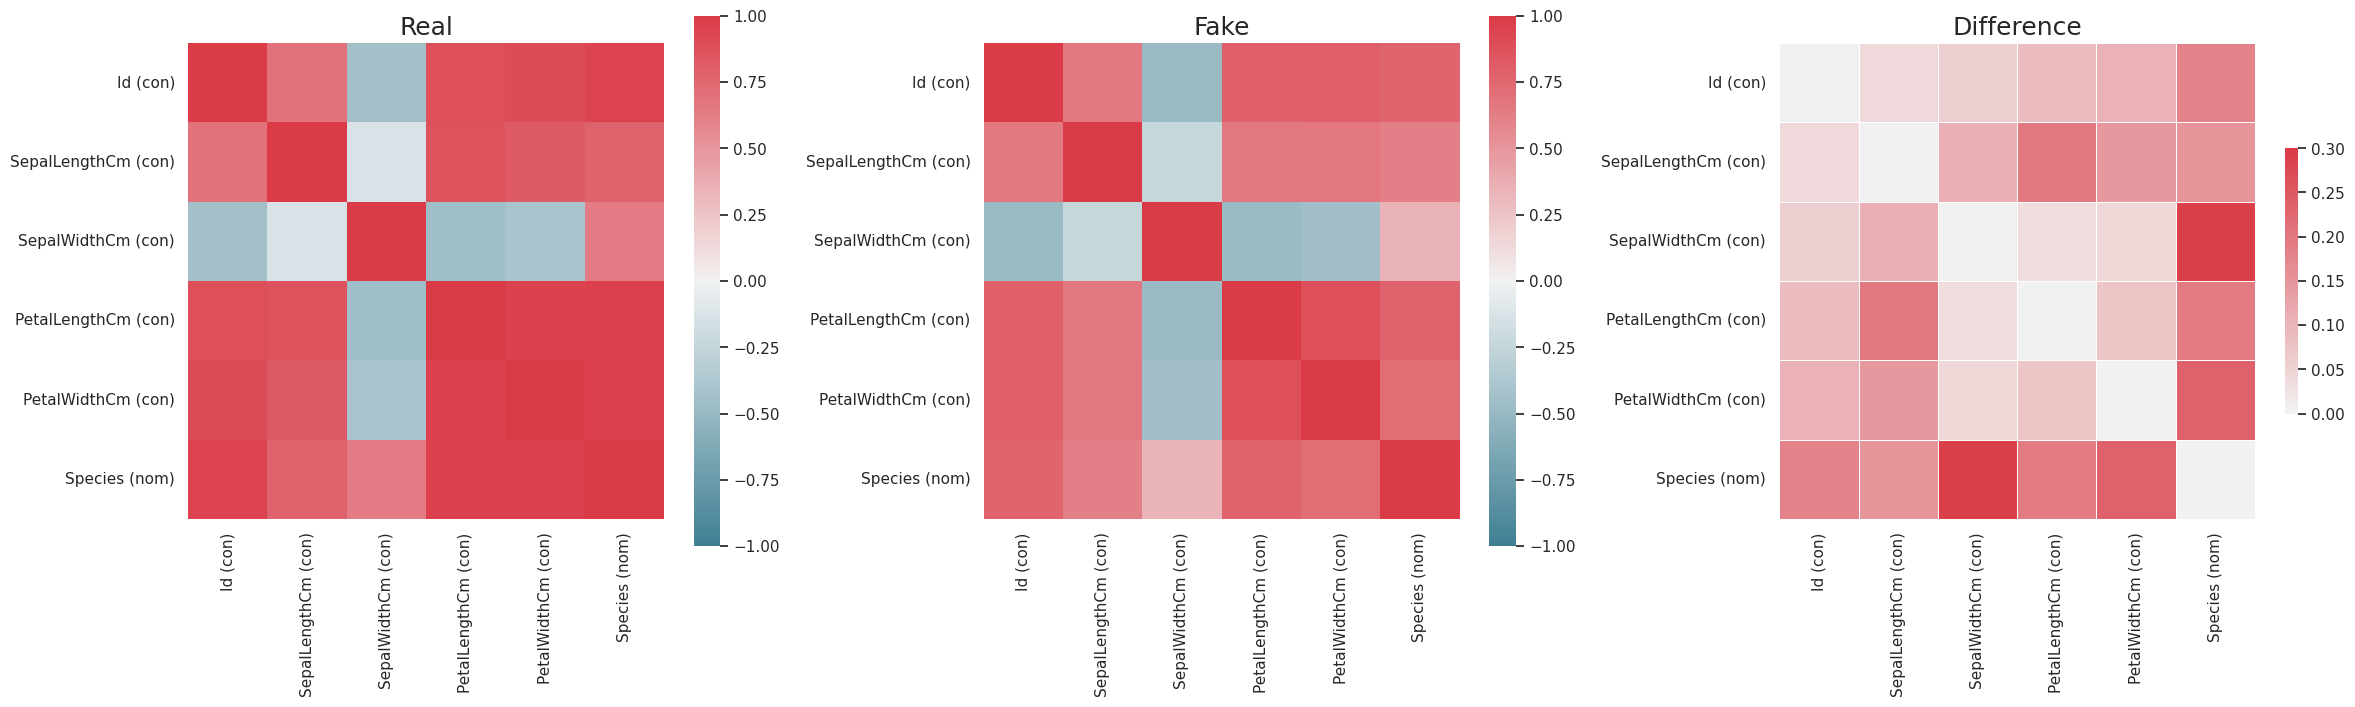

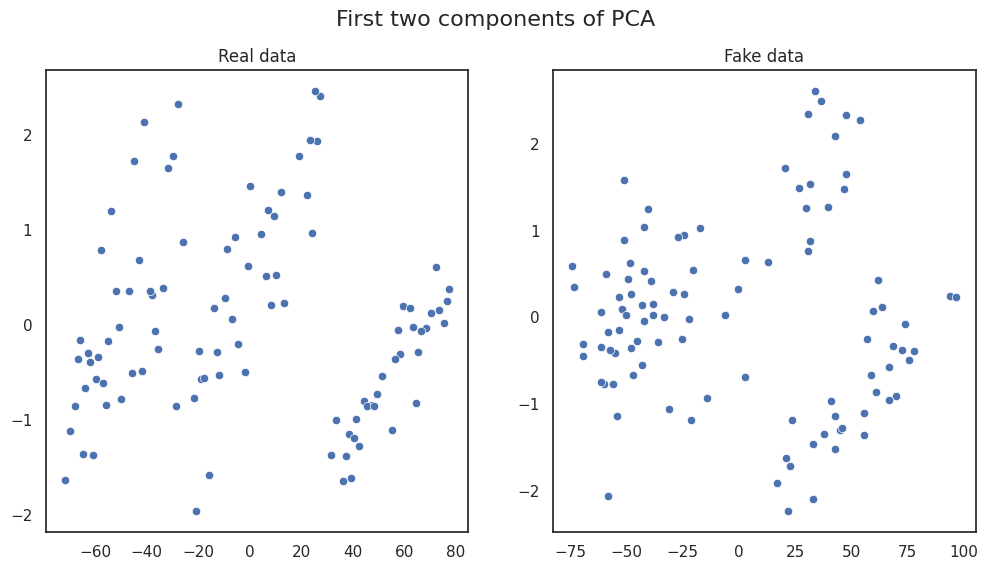

In [281]:
from table_evaluator import TableEvaluator

# Assuming real_data and synthetic_data are pandas DataFrames
table_evaluator = TableEvaluator(df, synthetic_data)

table_evaluator.visual_evaluation()

In [282]:
syn_df = pd.DataFrame(synthetic_data)

LINEAR REGRESSION

In [283]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [284]:
df_without_species = transformed_df.drop(columns=['Species'])
df_without_species.dropna()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,1.0,5.1,3.5,1.4,0.2
1,2.0,4.9,3.0,1.4,0.2
2,3.0,4.7,3.2,1.3,0.2
3,4.0,4.6,3.1,1.5,0.2
4,5.0,5.0,3.6,1.4,0.2
...,...,...,...,...,...
145,146.0,6.7,3.0,5.2,2.3
146,147.0,6.3,2.5,5.0,1.9
147,148.0,6.5,3.0,5.2,2.0
148,149.0,6.2,3.4,5.4,2.3


In [285]:
X_train_old,X_test_old,Y_train_old,Y_test_old = train_test_split(df_without_species,transformed_df['Species'],test_size=0.2,random_state=0)

In [286]:
new_df = ht.transform(syn_df)
new_df_without_species = new_df.drop(columns=['Species'])

In [287]:
X_train_new,X_test_new,Y_train_new,Y_test_new = train_test_split(new_df_without_species,new_df['Species'],test_size=0.2,random_state=0)

In [288]:
model_old = LinearRegression()
model_old.fit(X_train_old,Y_train_old)

LinearRegression()

In [289]:
# Trained on original data and tested on original data
score_old_old = model_old.score(X_test_old,Y_test_old)
print(f"The coefficient of determination is: {score_old_old:.6f}")

The coefficient of determination is: 0.816537


In [290]:
#Trained on original data and Testing on new Data
score_old_new = model_old.score(X_test_new,Y_test_new)
print(f"The coefficient of determination is: {score_old_new:.6f}")

The coefficient of determination is: 0.456659


In [291]:
#Training on new data
model_new = LinearRegression()
model_new.fit(X_train_new,Y_train_new)

LinearRegression()

In [292]:
#trained on new data and tested on Old data
score_new_old = model_new.score(X_test_old,Y_test_old)
print(f"The coefficient of determination is: {score_new_old:.6f}")

The coefficient of determination is: 0.808621


LOGISTIC REGRESSION

In [293]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
# Split the data into train and test sets

label_encoder = LabelEncoder()
df_copy = df.copy()
df_copy['Diagnosis_encoded'] = label_encoder.fit_transform(df_copy['Species'])

X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(df_without_species, df_copy['Diagnosis_encoded'], test_size=0.2, random_state=42)

In [294]:
syn_df['Diagnosis_encoded'] = label_encoder.fit_transform(syn_df['Species'])

X_train_new,X_test_new,Y_train_new,Y_test_new = train_test_split(new_df_without_species,syn_df['Diagnosis_encoded'],test_size=0.2,random_state=0)

In [295]:
log_reg_old = LogisticRegression()
log_reg_old.fit(X_train_old, y_train_old)

#Trained on original data and tested on original data
score_old_old = log_reg_old.score(X_test_old, y_test_old)
print(f"The coefficient of determination is: {score_old_old:.6f}")

The coefficient of determination is: 1.000000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [296]:
#Trained on original data and tested on new data
score_old_new = log_reg_old.score(X_test_new, Y_test_new)
print(f"The coefficient of determination is: {score_old_new:.6f}")

The coefficient of determination is: 0.650000


In [297]:
log_reg_new = LogisticRegression()
log_reg_new.fit(X_train_new, Y_train_new)

#Trained on new data and tested on original data
score_new_old = log_reg_new.score(X_test_old, y_test_old)
print(f"The coefficient of determination is: {score_new_old:.6f}")

The coefficient of determination is: 0.833333


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

